## Import functions

In [1]:
import pandas as  pd
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import sklearn
from numpy.typing import ArrayLike
import warnings
from dotenv import load_dotenv
import os
warnings.filterwarnings('ignore')

In [2]:
print("mlflow =",mlflow.__version__)
print("numpy =",np.__version__)
print("pandas =",pd.__version__)
print("sklearn =",sklearn.__version__)

mlflow = 2.3.2
numpy = 1.24.3
pandas = 2.0.2
sklearn = 1.2.2


## Import local functions

In [3]:
from utils.preprocessing import read, preprocessing, transform

# Setup  MLflow

run local:
```
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlflow/artifacts --host 0.0.0.0 -p 4600
```

run production:
```
run mlflow server --backend-store-uri postgresql://{USER_NAME}:{PASSWORD}@{HOST}:5432/{DATABASE_NAME} --default-artifact-root s3://{S3_BUCKET_NAME} -p 5000 -h 0.0.0.0
```

In [5]:
load_dotenv()

TRACKING_URI = os.getenv("TRACKING_URI")
EXPERIMENT_NAME = "california_housing_collaborative"

mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()

# Optimization function

In [6]:

target = 'median_house_value'
numerical = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']
categorical = ['ocean_proximity']

def compare_predictions(y_values: ArrayLike, y_prediction: ArrayLike) -> plt.Figure:
    fig, axs = plt.subplots()
    sns.distplot(y_prediction, label='Prediction')
    sns.distplot(y_values, label='Actual')
    plt.legend()
    plt.title('Comparison of Predicted Values and Actual Values')
    plt.xlabel('Values')
    plt.ylabel('Density')
    return fig

def run(df_train: pd.DataFrame, df_test: pd.DataFrame, num_trials=100):
    
    X_train = df_train.drop(columns=target)
    X_test = df_test.drop(columns=target)

    y_train = df_train[target].values
    y_test = df_test[target].values

    best_loss = float('inf')
    best_y_pred = None

    def objective(params):
        nonlocal best_loss, best_y_pred
        
        with mlflow.start_run():
            
            # Define customer tag
            tags = {"Application": "California Housing Prices Prediction",
                    "user": "michael",
                    "release.version": "1.1.0"}

            # Set Tag
            mlflow.set_tags(tags)
            
            rf = RandomForestRegressor(**params)
            rf.fit(X_train, y_train)
            
            y_pred_test = rf.predict(X_test)
            y_pred_train = rf.predict(X_train)
            
            val_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
            test_rmse = mean_squared_error(y_train, y_pred_train, squared=False)

            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            
            fig = compare_predictions(y_test, y_pred_test) 
            mlflow.log_figure(fig, 'Comparison of Predicted Values and Actual Values.png')
            
            
            mlflow.log_artifact('./data/preprocess/dv.pkl', artifact_path='dv.pkl')
            mlflow.log_artifact('./data/preprocess/scaler.pkl', artifact_path='scaler.pkl')
            
            
        if val_rmse < best_loss:
            best_loss = val_rmse
            best_y_pred = y_pred_test

        return {'loss': val_rmse, 'status': STATUS_OK}

    search_space = {
        'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
        'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
        'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
        'random_state': 42
    }

    rstate = np.random.default_rng(42)  # for reproducible results
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=num_trials,
        trials=Trials(),
        rstate=rstate
    )

    return best_y_pred, y_test



# Read dataframe

In [7]:
raw_housing = read('housing.csv')
raw_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,near_bay
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,near_bay
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,near_bay
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,near_bay
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,near_bay


<Axes: ylabel='Frequency'>

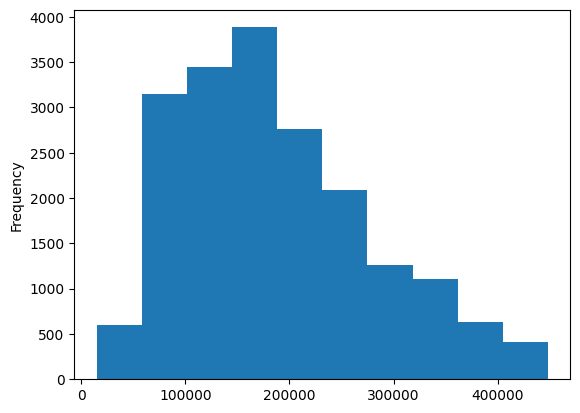

In [8]:
raw_housing['median_house_value'].plot.hist()

<Axes: >

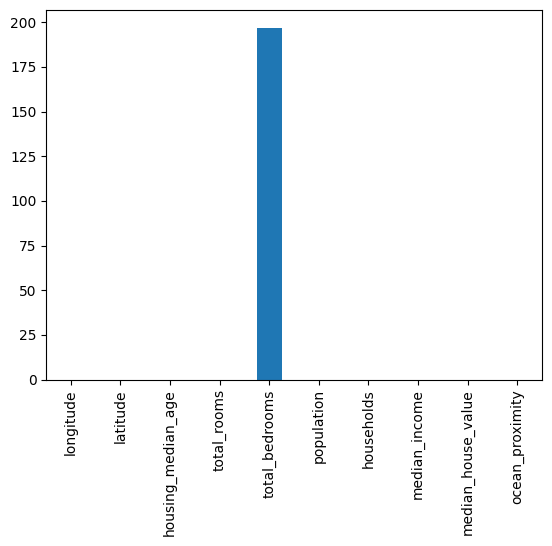

In [9]:
raw_housing.isnull().sum().plot.bar()

<Axes: xlabel='ocean_proximity'>

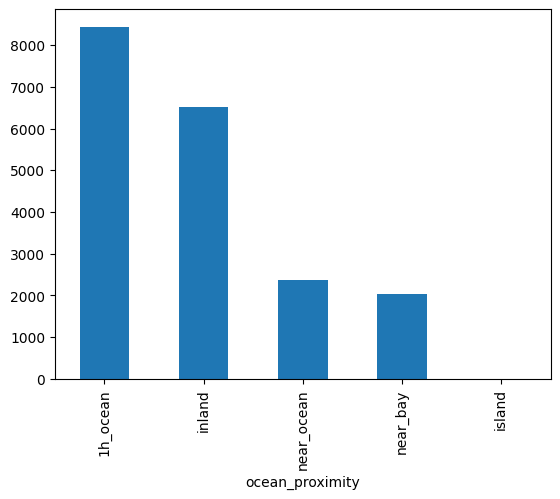

In [10]:
raw_housing.ocean_proximity.value_counts().plot.bar()

* Filling null values

# Preprocessing Dataset
* remove outliers in target value  
* remove ocean_proximity = ocean_proximity because has rare occurrence in dataset.
* fill na values with median.

In [11]:
preprocessing_housing = preprocessing(raw_housing)

# Training model, hyperparameter tuning 

In [12]:
from sklearn.model_selection import train_test_split

raw_train, raw_test= train_test_split(preprocessing_housing, test_size=0.25, random_state=43,shuffle=True)

In [13]:
raw_train.shape, raw_test.shape

((14421, 10), (4807, 10))

In [14]:
transform_train = transform(raw_train,fit=True,data_path='data/preprocess/')
transform_test = transform(raw_test,fit=False,data_path='data/preprocess/')


In [15]:
transform_train.head()

,ocean_proximity=1h_ocean,ocean_proximity=inland,ocean_proximity=island,ocean_proximity=near_bay,ocean_proximity=near_ocean,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,0.0,0.0,0.0,0.0,1.0,-1.058667,0.889474,0.578947,0.744757,0.672515,0.669831,0.798137,0.424885,12.334470
1,1.0,0.0,0.0,0.0,0.0,0.104000,-0.086842,0.368421,-0.174955,-0.359649,-0.376582,-0.295031,0.914855,12.687884
2,0.0,0.0,0.0,0.0,1.0,0.336000,-0.386842,0.210526,-0.301977,0.093567,-0.475738,0.055901,-0.418396,12.461881
3,0.0,0.0,0.0,1.0,0.0,-0.992000,0.918421,1.263158,0.098262,-0.330409,-0.397679,-0.279503,0.652484,12.722784
4,0.0,0.0,0.0,1.0,0.0,-0.978667,0.836842,0.473684,1.888556,2.701754,0.997890,2.649068,0.296449,12.884870


100%|██████████| 20/20 [06:17<00:00, 18.89s/trial, best loss: 0.2303603660386769]



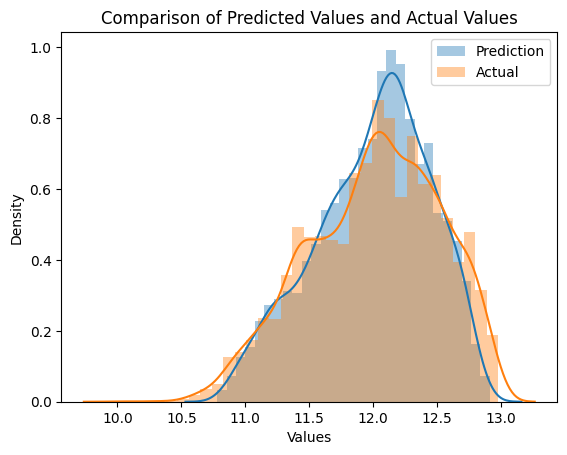

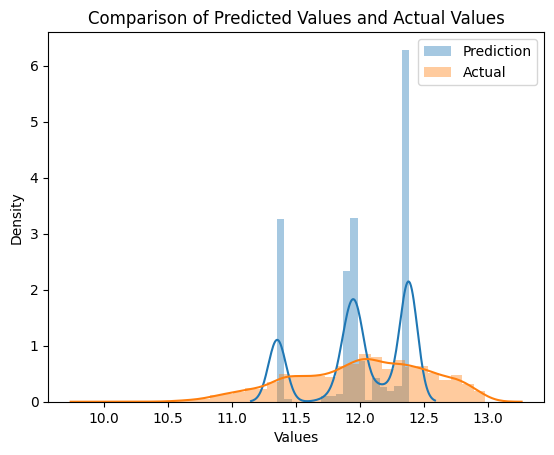

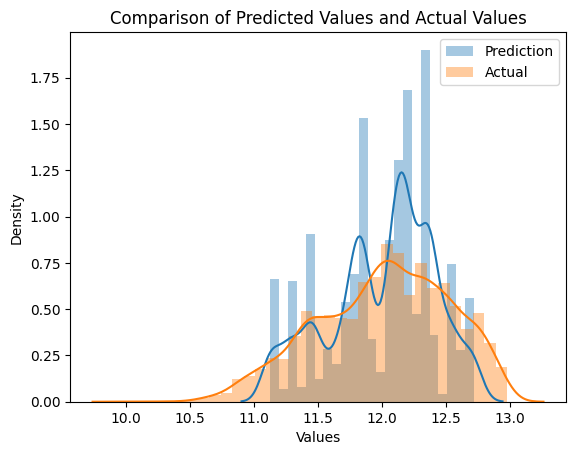

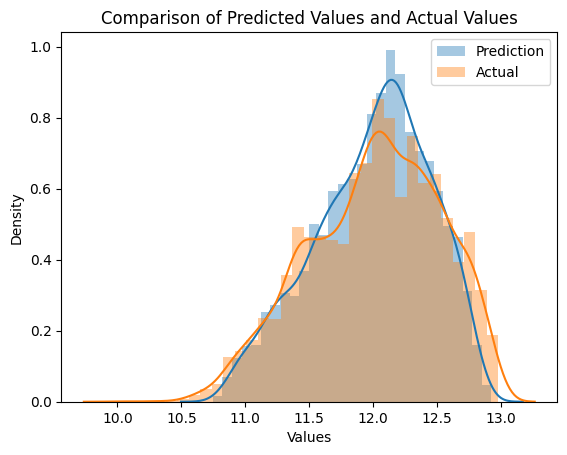

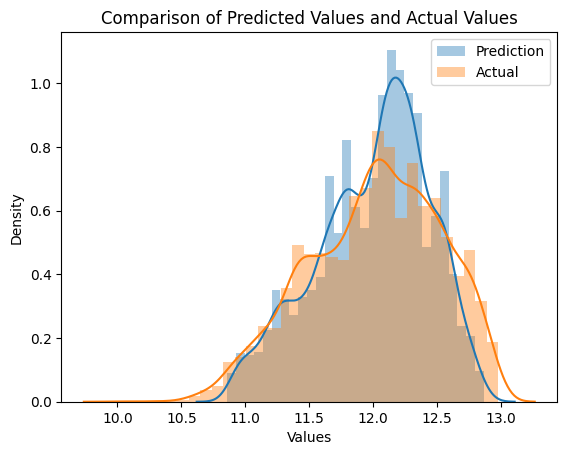

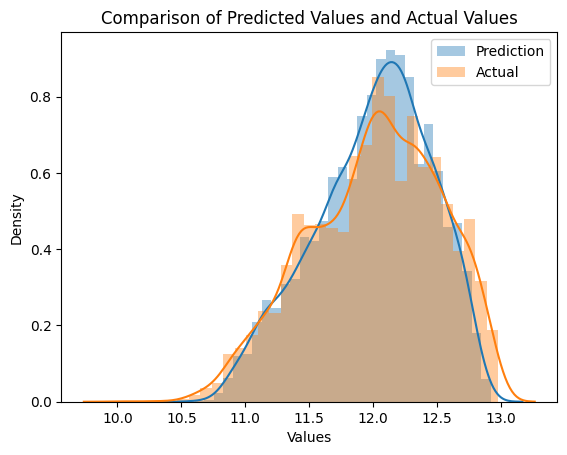

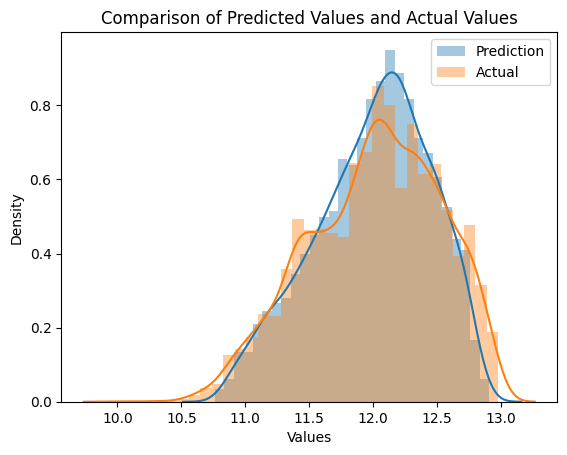

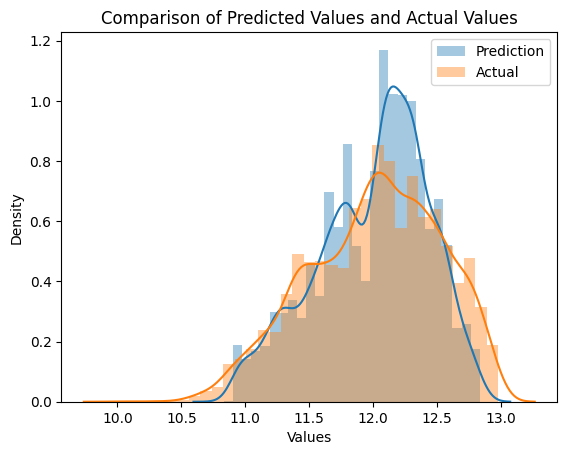

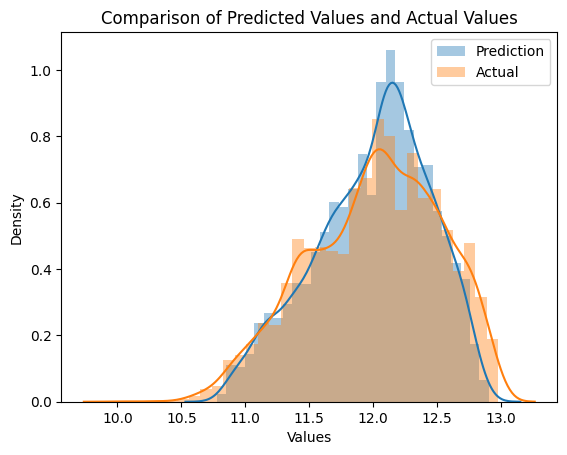

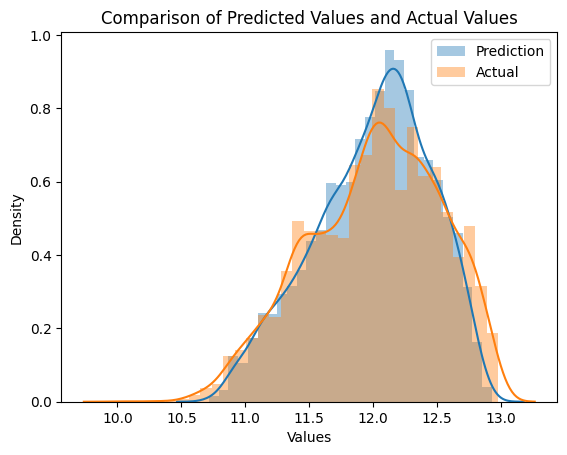

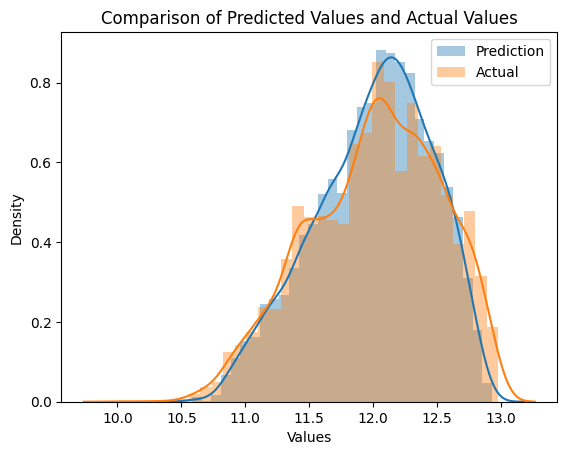

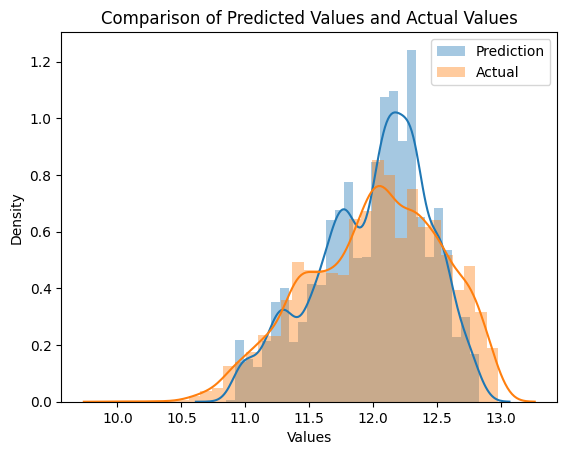

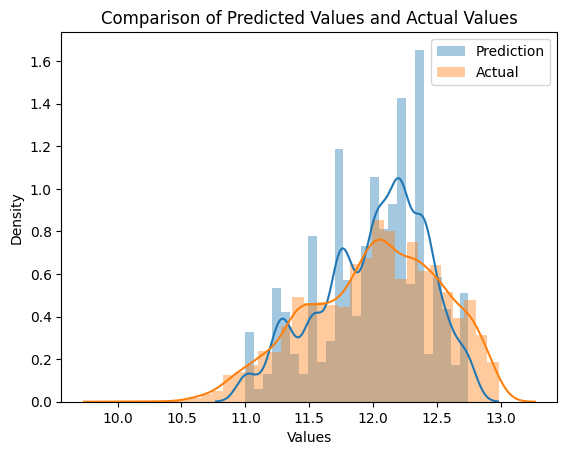

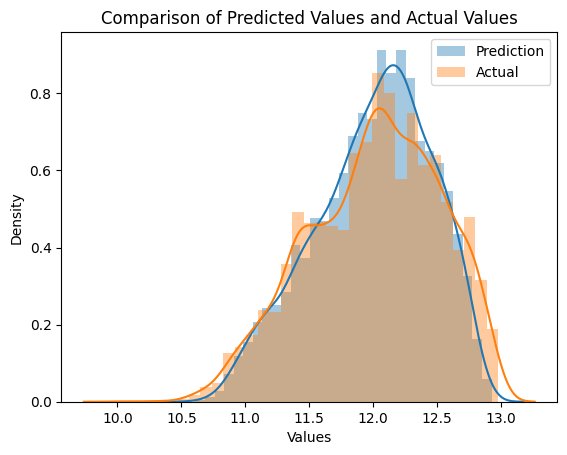

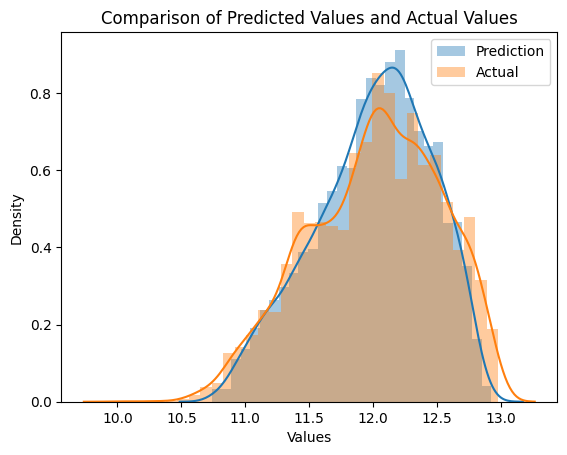

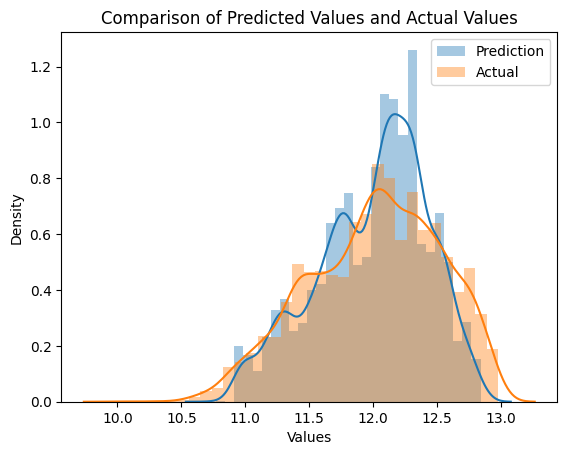

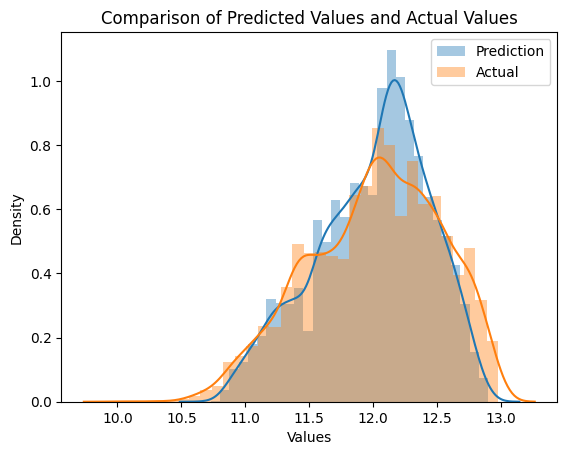

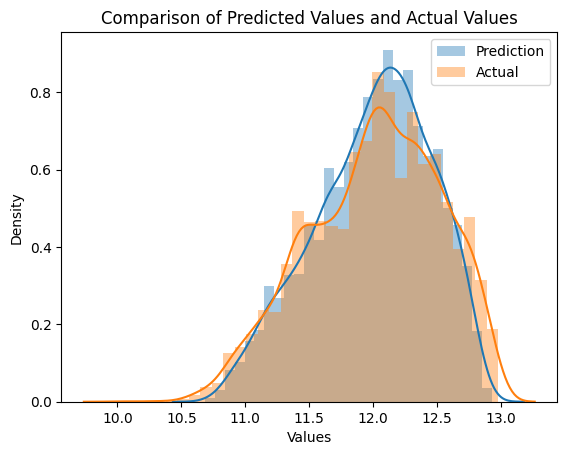

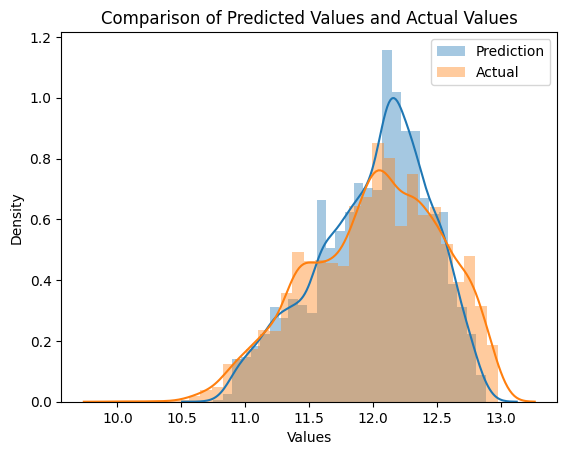

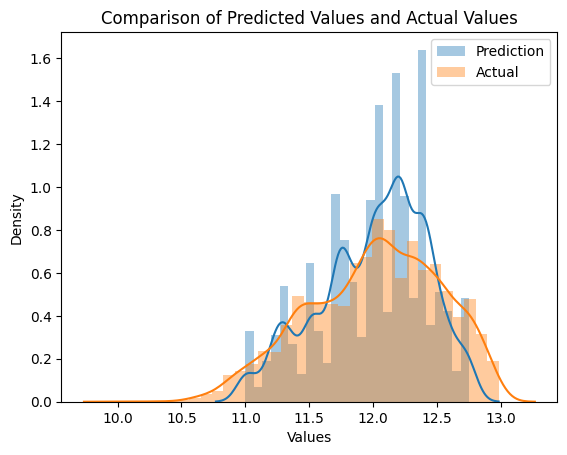

In [16]:
best_y_pred, y_test = run(transform_train,transform_test,20)
print()


In [ ]:
sns.distplot(best_y_pred, label='prediction')
sns.distplot(y_test, label='actual')

plt.legend()